In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from skimage.feature import hog

from sklearn import svm
from sklearn.model_selection import train_test_split

# Lendo dados

In [6]:
def process_image(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    return img_array

In [7]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img_binary = process_image(img_path)
            images.append(img_binary.flatten())
    return images

In [8]:
def load_strings_from_folder(folder_path):
    strings = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as file:
                    content = file.read().strip()
                    strings.append(content)
                    filenames.append(filename)
            except Exception as e:
                print(f"Erro ao ler o arquivo {file_path}: {e}")
    return strings, filenames

In [9]:
treinamento = load_images_from_folder('dados/CAPTCHA-10k/treinamento')
treinamento = np.array(treinamento)
validacao = load_images_from_folder('dados/CAPTCHA-10k/validacao')
validacao = np.array(validacao)
teste = load_images_from_folder('dados/CAPTCHA-10k/teste')
teste = np.array(teste)
labels = load_strings_from_folder('dados/CAPTCHA-10k/labels10k')[0]

In [16]:
treino_x = treinamento
treino_y = labels[:8000]

validacao_x = validacao
validacao_y = labels[8000:9000]

teste_x = teste
teste_y = labels[9000:]

In [19]:
def print_img(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()

In [20]:
def apply_unsharp_mask(image, kernel_size=(5, 5), sigma=1.5):
    kernel = np.array([[0, -1, 0],
                       [-1, 6,-1],
                       [0, -1, 0]])
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    return sharpened

In [21]:
def particionar_img(image_array):
    image_array = np.reshape(image_array, (50, 180))
    # print_img(image_array)
    particoes = []
    offset = 30
    for i in range(0, 6):
        particao = image_array[10: 45, 5+offset*i:45+offset*i]
        particoes.append(particao)
        particao = apply_unsharp_mask(particao)
        # print_img(particao)
    particoes[5] = np.pad(particoes[5], ((0, 0), (7, 8)), 'constant', constant_values=255)
    return particoes

In [22]:
def aplicar_particao(images):
    images_particionadas = []
    for i in range(len(images)):
        images_particionadas.extend(particionar_img(images[i]))
    return np.array(images_particionadas)

In [23]:
def particonar_strings(strings):
    strings_particionadas = []
    for i in range(0, len(strings)):
        for j in range(0, 6):
            strings_particionadas.append(strings[i][j])
    
    return np.array(strings_particionadas)

# HOG

In [ ]:
def preprocess_image(image_array):
    # Certifique-se de que a imagem está no formato correto (180x50)
    image_array = np.reshape(image_array, (50, 180))
    
    # Calcular os recursos HOG diretamente do array
    fd, hog_image = hog(image_array, orientations=64, pixels_per_cell=(50, 30),
                        cells_per_block=(1, 1), visualize=True)
    

    return fd, hog_image

# CNN

## Definindo e testando modelo

In [24]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [31]:
input_shape = (35, 40, 1)
num_classes = 37

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [26]:
set_caracteres = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?',
                  'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(set_caracteres)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

char_to_int = dict((c, i) for i, c in enumerate(set_caracteres))
int_to_char = dict((i, c) for i, c in enumerate(set_caracteres))

In [27]:
X_train = aplicar_particao(treino_x)
X_test = aplicar_particao(teste_x)
X_val = aplicar_particao(validacao_x)

y_train = particonar_strings(treino_y)
y_test = particonar_strings(teste_y)
y_val = particonar_strings(validacao_y)

In [28]:
y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)
y_val_int = label_encoder.transform(y_val)

y_train_onehot = onehot_encoder.transform(y_train_int.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_int.reshape(-1, 1))
y_val_onehot = onehot_encoder.transform(y_val_int.reshape(-1, 1))

In [32]:
model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val, y_val_onehot))

Epoch 1/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9722 - accuracy: 0.8471 - val_loss: 0.2162 - val_accuracy: 0.9315
Epoch 2/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1336 - accuracy: 0.9627 - val_loss: 0.1848 - val_accuracy: 0.9472
Epoch 3/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0876 - accuracy: 0.9726 - val_loss: 0.2063 - val_accuracy: 0.9437
Epoch 4/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0639 - accuracy: 0.9790 - val_loss: 0.2521 - val_accuracy: 0.9455
Epoch 5/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0555 - accuracy: 0.9823 - val_loss: 0.2428 - val_accuracy: 0.9443
Epoch 6/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0426 - accuracy: 0.9861 - val_loss: 0.3235 - val_accuracy: 0.9455
Epoch 7/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0343 - accuracy: 0.9889 - val_loss: 0.3269 - val_ac

## Avaliando modelo

In [34]:
loss, accuracy = model.evaluate(X_test, y_test_onehot)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

188/188 [==============================] - 1s 5ms/step - loss: 0.3567 - accuracy: 0.9532
Test Loss: 0.35668185353279114
Test Accuracy: 0.953166663646698


In [36]:
# Gráfico de taxa de reconhecimento
# Prever rótulos no conjunto de testes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Gerar vetor de 0s e 1s indicando acertos (1) e erros (0)
accuracy_vector = (y_pred_classes == y_true).astype(int)

188/188 [==============================] - 1s 4ms/step


In [37]:
print("Accuracy Vector:", accuracy_vector)
print("Number of correct predictions:", np.sum(accuracy_vector))
print("Number of incorrect predictions:", len(accuracy_vector) - np.sum(accuracy_vector))

Accuracy Vector: [1 1 1 ... 1 1 1]
Number of correct predictions: 5719
Number of incorrect predictions: 281


In [68]:
caracteres_reconhecidos = np.zeros(7)
for i in range(0, 1000):
    soma = 0
    for j in range(0, 6):
        if accuracy_vector[i * 6 + j] == 1:
            soma += 1
    
    caracteres_reconhecidos[soma] += 1

In [58]:
frequencias = np.zeros(7)
for i in range(0, 7):
    frequencia = 0
    for j in range(i, 7):
        frequencia += caracteres_reconhecidos[j]
    frequencias[i] = frequencia
frequencias = frequencias/1000

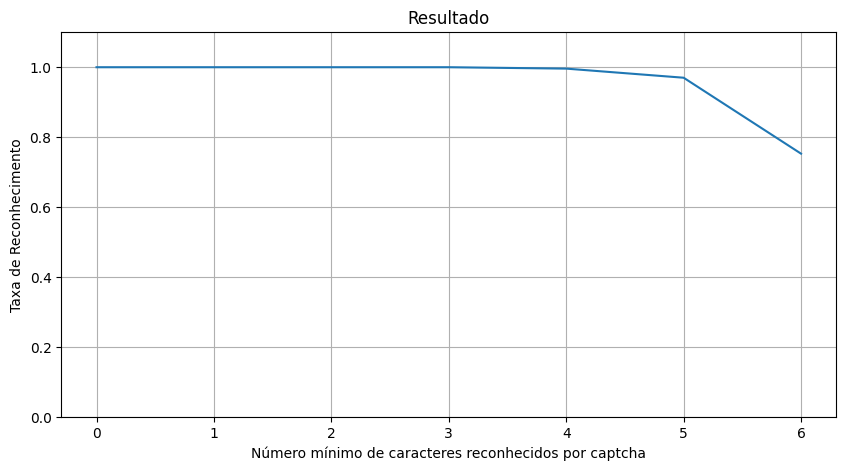

In [65]:
x_values = [0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(10, 5))
plt.plot(x_values, frequencias)

plt.title('Resultado')
plt.xlabel('Número mínimo de caracteres reconhecidos por captcha')
plt.ylabel('Taxa de Reconhecimento')
plt.ylim(0, 1.1)
plt.grid(True)

plt.show()